In [60]:
import torch
import os
import json
import tqdm
import collections
import random
import matplotlib.pyplot as plt
import numpy as np
import scipy

import utils
import som

import PIL
import PIL.ImageDraw
import cv2

In [2]:
fnames = os.listdir("data")
fields = ['name','smiles','notes']
molecules = []
for fname in tqdm.tqdm(fnames):
    with open(os.path.join("data",fname)) as f:
        mol = json.load(f)
        data = {k:mol[k] for k in fields}
        # Check that the molecule has all the fields of interest
        if all(data.values()):
            molecules.append(data)

# Have to de-dupe the notes for each molecule.
for mol in molecules:
    mol["notes"] = set(mol["notes"])
    
print(f"Found {len(molecules)} molecules.")
molecules[:3]

100%|███████████████████████████████████| 19194/19194 [00:02<00:00, 6770.42it/s]

Found 3440 molecules.


[{'name': 'amyl butyrate',
  'smiles': 'CCCCCOC(=O)CCC',
  'notes': {'banana', 'cherry', 'fruity', 'pineapple', 'sweet', 'tropical'}},
 {'name': 'para-anisyl phenyl acetate',
  'smiles': 'COC1=CC=C(C=C1)COC(=O)CC2=CC=CC=C2',
  'notes': {'anise', 'balsamic', 'honey', 'woody'}},
 {'name': 'dihydrofarnesol',
  'smiles': 'CC(CC/C=C(\\C)/CCC=C(C)C)CCO',
  'notes': {'cyclamen', 'floral', 'metallic'}}]

In [3]:
all_notes = collections.Counter()
for mol in molecules:
    all_notes.update(mol["notes"])
print(f"Found {len(all_notes)} unique notes.")
print("Most common:")
print(all_notes.most_common(5))

Found 502 unique notes.
Most common:
[('fruity', 1060), ('green', 967), ('sweet', 884), ('floral', 706), ('woody', 558)]


In [4]:
all_notes_list = list(all_notes.keys())

def multi_hot(notes):
    indices = torch.tensor([all_notes_list.index(n) for n in notes])
    if len(indices) == 0:
        # Occurs when the notes in the pair were removed due to infrequency.
        raise AttributeError("Found no valid notes.")
    one_hots = torch.nn.functional.one_hot(indices, len(all_notes))
    return one_hots.sum(dim=0).float()

for mol in molecules:
    mol["encoding"] = multi_hot(mol["notes"])

print(molecules[0])

{'name': 'amyl butyrate', 'smiles': 'CCCCCOC(=O)CCC', 'notes': {'sweet', 'banana', 'pineapple', 'tropical', 'cherry', 'fruity'}, 'encoding': tensor([1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [5]:
def do_train(config,verbose=False):
    shape = (config["width"], config["height"], len(all_notes_list))
    map = som.SOM(shape=shape,
              wrapping=som.WrappingMode.SPHERICAL,
              gauss=config["gauss"],
              decay=config["decay"],
              use_onehot=config["onehot"],
              clip_models=True,
              use_tanh=True)

    encodings = torch.stack([mol["encoding"] for mol in molecules])

    # steps = int(config["width"] * config["height"])
    # steps = config["width"], config["height"]
    steps = int((config["width"] * config["height"]))
    for i in tqdm.tqdm(range(steps),smoothing=0, disable=not verbose):
        map.update_batch(encodings)
        map.do_decay()

    print(map.gauss)
    return map

step = .05

# In general, the larger the initial gauss, the longer the training will have to be
# Though using a stronger decay reduces this.
# A larger initial gauss does tend to lead to better distributions, though.

all_models = []
all_params = []

w, h = 1, 1

for size in [(20,16)]:
    for decay in [.9]:
        mapw, maph = size
        params = {'width': mapw, 'height': maph, "gauss":min(mapw,maph)/2, "decay": decay, "onehot": True}
        all_models.append(do_train(params,verbose=True))
        all_params.append({"size":size,"decay":decay})
        


100%|█████████████████████████████████████████| 320/320 [02:15<00:00,  2.36it/s]

0.8


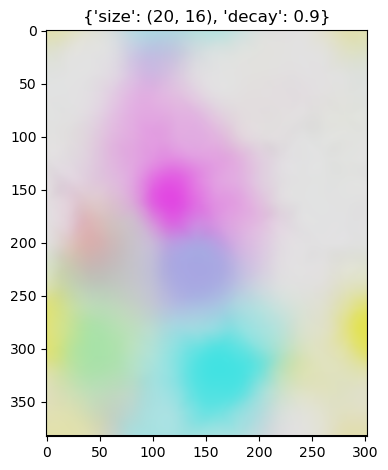

In [6]:
def to_img_array(map,encoding,step,invert,thresh=0):
    _, rsz_actvn, rsz_shape, bmu_pos  = map.get_interpolated_activations(encoding,step,method="cubic")
    mtrx = torch.nn.functional.threshold(rsz_actvn,thresh,0).reshape(*rsz_shape).numpy()
    if invert:
        mtrx = 1-mtrx
    mtrx_norm = mtrx*255
    
    return clean(mtrx_norm), bmu_pos

def add_border(pil_img, border):
    width, height = pil_img.size
    new_width = width + 2*border
    new_height = height + 2*border
    result = PIL.Image.new(pil_img.mode, (new_width, new_height), 0)
    result.paste(pil_img, (border, border))
    return result

def clean(img_array):
    assert img_array.min() >= 0 and img_array.max() <= 255
    return img_array.astype('uint8')
    

def make_bw_pil(img_array, border=0):
    assert img_array.dtype=="uint8"
    assert img_array.min() >= 0 and img_array.max() <= 255
    w,h = img_array.shape
    img = PIL.Image.fromarray(img_array,mode="L")
    return add_border(img,border)

def make_rgb_pil(img_array,border=0):
    assert img_array.dtype=="uint8"
    assert img_array.min() >= 0 and img_array.max() <= 255
    w,h,c = img_array.shape
    assert c == 3
    img = PIL.Image.fromarray(img_array,mode="RGB")
    return add_border(img,border)

rgb_imgs = []
for map in all_models:
    all_imgs = []
    for n,f in all_notes.most_common(3):
        bmu = map.get_bmu(multi_hot([n]))
        imgar, _ = to_img_array(map,multi_hot([n]),step=step,invert=True,thresh=0)
        all_imgs.append(imgar)
    rgb_imgs.append(np.stack(all_imgs,axis=-1))

for i in range(len(all_models)):
    plt.imshow(make_rgb_pil(rgb_imgs[i],1))
    plt.title(all_params[i])
plt.tight_layout()
plt.show()

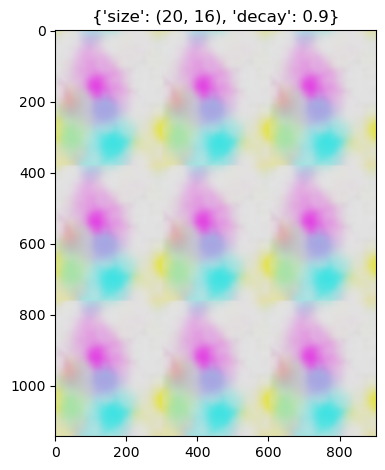

In [7]:
# Attempting to tile the np arrays causes the border to be too thick.
def tile_pil(pil_img,tile_w,tile_h):
    w,h = pil_img.width, pil_img.height
    dst = PIL.Image.new(pil_img.mode, (w*tile_w, h*tile_h))
    for x in range(tile_w):
        for y in range(tile_h):
            dst.paste(pil_img,(x*w,y*h))
    return dst

for i in range(len(all_models)):
    plt.imshow(tile_pil(make_rgb_pil(rgb_imgs[i],0),3,3))
    plt.title(all_params[i])
plt.tight_layout()
plt.show()

In [172]:
palette = ["EF476F","FFD166","06D6A0","118AB2"]

def draw_square(color):
    display(PIL.Image.new("RGB", (20, 20), color))

# Roughly the center
color_array = []
for i,color in enumerate(palette):
    rgb_color = PIL.ImageColor.getrgb(f"#{color}")
    color_array.append(rgb_color)
    draw_square(rgb_color)

color_array = np.stack(color_array)

all_layers = []
for map in all_models:
    layers = []
    for n,f in tqdm.tqdm(all_notes.most_common(4)):
        imgar, _ = to_img_array(map,multi_hot([n]),step=step,invert=False)
        layers.append(imgar)
    layers = np.stack(layers,axis=-1)
    all_layers.append(layers)

100%|█████████████████████████████████████████████| 4/4 [00:17<00:00,  4.42s/it]


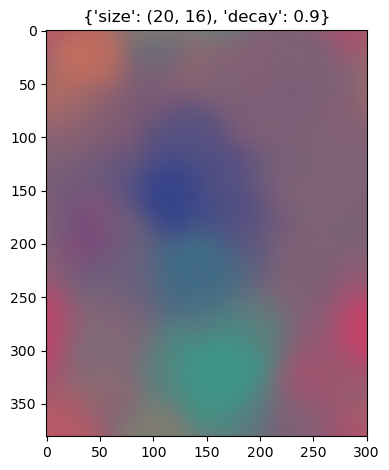

In [9]:
for i,layers in enumerate(all_layers):
    layer_weights = layers.astype(float)/255
    layer_color = np.matmul(layer_weights,color_array) / (layer_weights.sum(axis=-1,keepdims=True))
    layer_color = np.nan_to_num(layer_color,0)
    layer_color = clean(layer_color)

    plt.imshow(make_rgb_pil(255-layer_color))
    plt.title(all_params[i])
plt.tight_layout()
plt.show()

0.0 153.29999999999998


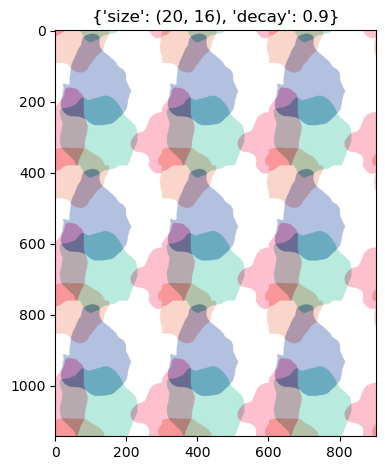

In [10]:
for i,layers in enumerate(all_layers):
    layer_weights = layers.astype(float)/255
    threshed_weights = np.where(layer_weights > .2, .3, 0)
    with np.errstate(divide='ignore', invalid='ignore'):
        layer_color = np.matmul(threshed_weights,color_array)
    layer_color = np.nan_to_num(layer_color,0,posinf=0,neginf=0)
    print(layer_color.min(),layer_color.max())
    layer_color = clean(layer_color)

    plt.imshow(tile_pil(make_rgb_pil(255-layer_color),3,3))
    plt.title(all_params[i])
plt.tight_layout()
plt.show()

0.0 174.7372549019608


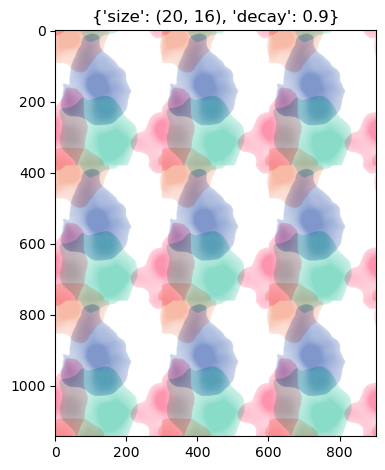

In [11]:
for i,layers in enumerate(all_layers):
    layer_weights = layers.astype(float)/255
    threshed_weights = np.where(layer_weights > .2, np.clip(layer_weights, a_min=0,a_max=.5), 0)
    with np.errstate(divide='ignore', invalid='ignore'):
        layer_color = np.matmul(threshed_weights,color_array)
    # break
    layer_color = np.nan_to_num(layer_color,0,posinf=0,neginf=0)
    print(layer_color.min(),layer_color.max())
    # layer_color = np.clip(layer_color, a_min=0, a_max=255)
    layer_color = clean(layer_color)

    plt.imshow(tile_pil(make_rgb_pil(255-layer_color),3,3))
    plt.title(all_params[i])
plt.tight_layout()
plt.show()

In [12]:
# https://github.com/JustGlowing/minisom/blob/master/minisom.py#L538
# def quantization_error(self, data):
#     """Returns the quantization error computed as the average
#     distance between each input sample and its best matching unit."""
#     self._check_input_len(data)
#     return norm(data-self.quantization(data), axis=1).mean()

# def topographic_error(self, data):
#     """Returns the topographic error computed by finding
#     the best-matching and second-best-matching neuron in the map
#     for each input and then evaluating the positions.

#     A sample for which these two nodes are not adjacent counts as
#     an error. The topographic error is given by the
#     the total number of errors divided by the total of samples.

#     If the topographic error is 0, no error occurred.
#     If 1, the topology was not preserved for any of the samples."""

In [13]:
for n, f in all_notes.most_common(30):
    print(n)

fruity
green
sweet
floral
woody
herbal
fresh
fatty
waxy
spicy
rose
citrus
earthy
tropical
oily
nutty
balsamic
sulfurous
vegetable
powdery
creamy
musty
apple
minty
pineapple
meaty
aldehydic
phenolic
dry
caramellic


  0%|                                                     | 0/4 [00:00<?, ?it/s]

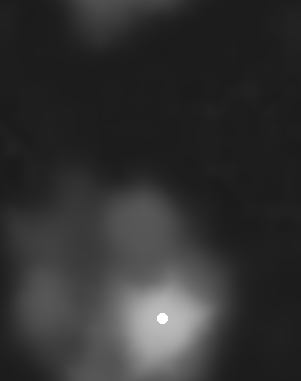

 25%|███████████▎                                 | 1/4 [00:04<00:13,  4.44s/it]

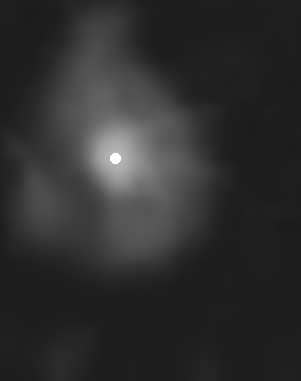

 50%|██████████████████████▌                      | 2/4 [00:08<00:08,  4.39s/it]

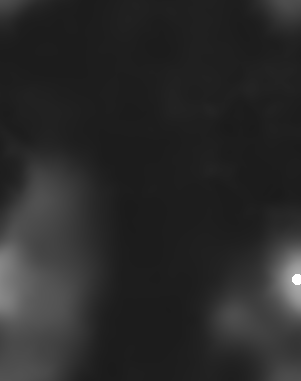

 75%|█████████████████████████████████▊           | 3/4 [00:13<00:04,  4.38s/it]

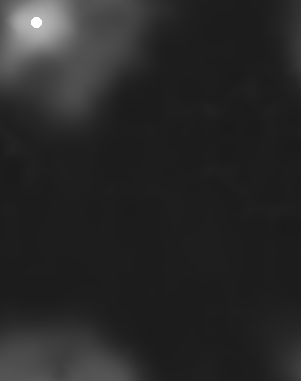

100%|█████████████████████████████████████████████| 4/4 [00:17<00:00,  4.40s/it]


In [164]:
def convert_bmu_pos(step,bmu_idx):
    w, h = bmu_idx
    # This is inverted b/c I dont know
    y0,x0 = (w)/step,(h)/step
    return int(x0),int(y0)

def draw_bmus(pil_img,step,bmu_idxs,r=5,fill="white"):
    dimg = PIL.ImageDraw.Draw(pil_img)
    for bmu_idx in bmu_idxs:
        x,y = convert_bmu_pos(step,bmu_idx)
        dimg.ellipse([x-r,y-r,x+r,y+r],fill=fill)
    return dimg._image

for map in all_models:
    layers = []
    for n,f in tqdm.tqdm(all_notes.most_common(4)):
        imgar, bmu_pos = to_img_array(map,multi_hot([n]),step=step,invert=False)
        display(draw_bmus(make_bw_pil(imgar),step,[bmu_pos.numpy()]))
        # draw_bmus(
        # plt.imshow(make_bw_pil(imgar,1),cmap="Greys")
        # plt.show()


  0%|                                                    | 0/10 [00:00<?, ?it/s]

(77, 61)


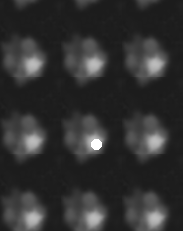

 10%|████▍                                       | 1/10 [00:00<00:05,  1.75it/s]

(77, 61)


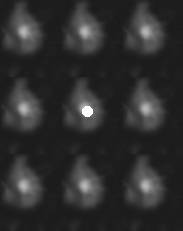

 20%|████████▊                                   | 2/10 [00:01<00:04,  1.82it/s]

(77, 61)


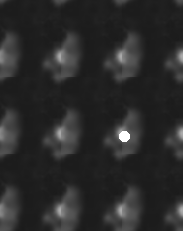

 30%|█████████████▏                              | 3/10 [00:01<00:03,  1.85it/s]

(77, 61)


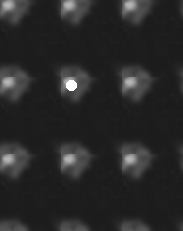

 40%|█████████████████▌                          | 4/10 [00:02<00:03,  1.86it/s]

(77, 61)


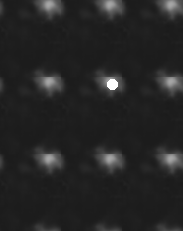

 50%|██████████████████████                      | 5/10 [00:02<00:02,  1.86it/s]

(77, 61)


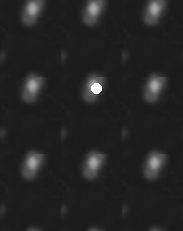

 60%|██████████████████████████▍                 | 6/10 [00:03<00:02,  1.87it/s]

(77, 61)


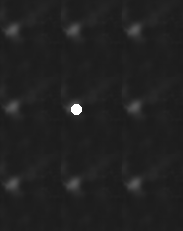

 70%|██████████████████████████████▊             | 7/10 [00:03<00:01,  1.87it/s]

(77, 61)


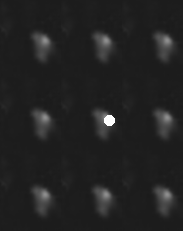

 80%|███████████████████████████████████▏        | 8/10 [00:04<00:01,  1.87it/s]

(77, 61)


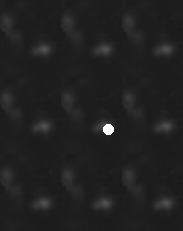

 90%|███████████████████████████████████████▌    | 9/10 [00:04<00:00,  1.87it/s]

(77, 61)


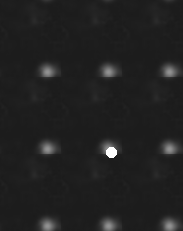

100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.86it/s]


In [99]:
all_layers = []
for map in all_models:
    layers = []
    for n,f in tqdm.tqdm(all_notes.most_common(10)):
        ns = .25
        imgar, bmu_pos = to_img_array(map,multi_hot([n]),step=ns,invert=False)
        print(imgar.shape)
        tiled_bmu_pos = bmu_pos + torch.FloatTensor([map.width,map.height])
        tiled_img = tile_pil(make_bw_pil(imgar),3,3)
        display(draw_bmus(tiled_img,ns,[tiled_bmu_pos.numpy()]))
        # draw_bmus(
        # plt.imshow(make_bw_pil(imgar,1),cmap="Greys")
        # plt.show()


In [ ]:
all_flooded = []
for map in all_models:
    flooded = []
    for n,f in tqdm.tqdm(all_notes.most_common()):
        ns = .1
        imgar, bmu_pos = to_img_array(map,multi_hot([n]),step=ns,invert=False)
        tiled_bmu_pos = bmu_pos + torch.FloatTensor([map.width,map.height])
        x,y = convert_bmu_pos(ns,tiled_bmu_pos.numpy())
        imgar = np.tile(imgar,[3,3])
        imgar = np.where(imgar > 35, 255,0).astype('uint8')
        blank = np.zeros(imgar.shape)
        # For reasons I cannot explain, the mask should have 0 where it can be filled
        # Sort of nonsense but that's fine I guess.
        num,im,mask,rect = cv2.floodFill(blank.astype('uint8'), 255-np.pad(imgar,1), (x,y), 255)
        plt.imshow(im,cmap="Greys")
        plt.title(f"{n} {num}")
        print(im.shape)
        plt.show()

        flooded.append(im)
    flooded = np.stack(flooded,axis=-1)
    all_flooded.append(flooded)

  0%|                                                   | 0/502 [00:00<?, ?it/s]

(8, 3)
0.0 255.0 73


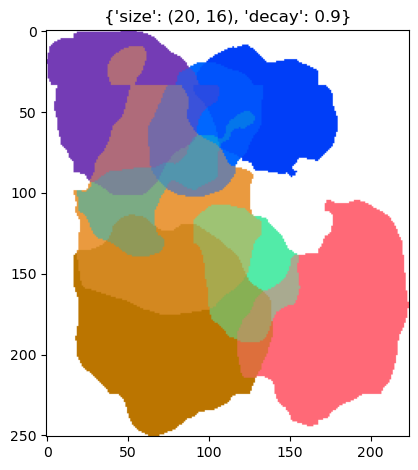

In [258]:
def trim_zeros(arr):
    # https://stackoverflow.com/a/65547931/19934620
    """Returns a trimmed view of an n-D array excluding any outer
    regions which contain only zeros.
    """
    slices = tuple(slice(idx.min(), idx.max() + 1) for idx in np.nonzero(arr))
    return arr[slices]

palette = ["448aff","1565c0","009688","8bc34a","ffc107","ff9800","f44336","ad1457"]

# Roughly the center
color_array = []
for i,color in enumerate(palette):
    rgb_color = PIL.ImageColor.getrgb(f"#{color}")
    color_array.append(rgb_color)
    draw_square(rgb_color)

color_array = np.stack(color_array)
print(color_array.shape)

for i,flooded in enumerate(all_flooded):
    flooded = flooded[...,:len(color_array)]
    flooded_weights = flooded.astype(float)/255
    with np.errstate(divide='ignore', invalid='ignore'):
        layer_color = np.matmul(flooded_weights,color_array) / (flooded_weights.sum(axis=-1,keepdims=True))
    layer_color = np.nan_to_num(layer_color,0)
    print(layer_color.min(),layer_color.max(),len(np.unique(layer_color)))
    # layer_color = layer_color*.6
    layer_color = clean(layer_color)
    trimmed = trim_zeros(layer_color)
    plt.imshow(make_rgb_pil(255-trimmed))
    plt.title(all_params[i])
plt.tight_layout()
plt.show()